In [24]:
#Importing libraries
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import re
import math
from collections import Counter, defaultdict
from typing import List, Dict, Any

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
#Loading the data
df = pd.read_csv('/content/drive/MyDrive/rideshare_kaggle.csv')

#Add datetime features
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
df['hour'] = df['datetime'].dt.hour
df['day_name'] = df['datetime'].dt.day_name()
df['day_of_week'] = df['datetime'].dt.dayofweek

#Filter to rides with price data for search corpus
df_search = df.dropna(subset=['price', 'source', 'destination', 'distance']).copy()

In [26]:
def trip_to_document(row, include_price=True):
    """
    Convert a trip record to a text document.
    Include unique identifiers to distinguish similar routes.
    """
    doc = (
        f"source {row['source']} "
        f"destination {row['destination']} "
        f"hour {row['hour']} "
        f"{row['day_name']} "
        f"distance {row['distance']:.1f} miles "
        f"surge {row['surge_multiplier']} "
        f"{row['cab_type']} "
        f"{row['short_summary']} weather"
    )
    if include_price:
        doc += f" price {row['price']:.0f}"
    return doc

#Create corpus make sure we're getting trips
print("Creating trip document corpus...")
CORPUS = []

#Sample diverse trips instead of just first 5000
#Group by route and sample to get variety
for idx, row in df_search.sample(5000, random_state=42).iterrows():  # Random sample for diversity
    CORPUS.append({
        "id": f"trip{idx}",
        "title": f"{row['source']} → {row['destination']}",
        "text": trip_to_document(row),
        "price": row['price'],
        "cab_type": row['cab_type'],
        "surge_multiplier": row['surge_multiplier'],
        "distance": row['distance'],
        "hour": row['hour'],
        "day": row['day_name']
    })

print(f"✓ Created corpus of {len(CORPUS):,} trip documents")
print(f"\nExample document:")
print(f"Title: {CORPUS[0]['title']}")
print(f"Text: {CORPUS[0]['text']}")

Creating trip document corpus...
✓ Created corpus of 5,000 trip documents

Example document:
Title: Financial District → Fenway
Text: source Financial District destination Fenway hour 21 Sunday distance 4.5 miles surge 1.0 Lyft  Overcast  weather price 7


In [27]:
## Step 1. ##

#Tokenizing the document into words
def tokenize(text: str) -> List[str]:
    """
    Input: A text string
    Output: List of lowercase words
    """
    return re.findall(r"[a-zA-Z0-9']+", text.lower())

#Test tokenization
sample_text = CORPUS[0]['text']
sample_tokens = tokenize(sample_text)

print(f"Original text: {sample_text}")
print(f"\nTokenized: {sample_tokens}")
print(f"Total tokens: {len(sample_tokens)}")

#Get all words from each document in the corpus
DOC_TOKENS = [tokenize(d["title"] + " " + d["text"]) for d in CORPUS]

#Get all unique words across corpus
VOCAB = sorted(set(t for doc in DOC_TOKENS for t in doc))

print(f"✓ Tokenized {len(DOC_TOKENS):,} documents")
print(f"✓ Vocabulary size: {len(VOCAB):,} unique tokens")

Original text: source Financial District destination Fenway hour 21 Sunday distance 4.5 miles surge 1.0 Lyft  Overcast  weather price 7

Tokenized: ['source', 'financial', 'district', 'destination', 'fenway', 'hour', '21', 'sunday', 'distance', '4', '5', 'miles', 'surge', '1', '0', 'lyft', 'overcast', 'weather', 'price', '7']
Total tokens: 20
✓ Tokenized 5,000 documents
✓ Vocabulary size: 95 unique tokens


In [28]:
## Step 2. ##

#Compute term frequencie
def compute_tf(tokens: List[str]) -> Dict[str, float]:

    #Count word occurrences
    counts = defaultdict(int)
    for token in tokens:
        counts[token] += 1

    #Normalize by document length
    length = max(1, len(tokens))
    tf = {token: counts[token] / length for token in counts}

    return tf

In [29]:
## Step 3. ##

#Computing document frequency
def compute_df(doc_tokens: List[List[str]]) -> Dict[str, float]:
    """
    Input: A list of lists of tokens in each document
    Output: A dictionary of the counts of each word appearing across documents
    """
    df = defaultdict(int)
    for tokens in doc_tokens:
        #Count each unique word once per document
        for token in set(tokens):
            df[token] += 1
    return df

#Compute DF
DF = compute_df(DOC_TOKENS)
N_DOC = len(DOC_TOKENS)

#Compute IDF
IDF = {word: math.log((N_DOC + 1) / (DF[word] + 0.5)) + 1 for word in VOCAB}

In [30]:
## Step 4. ##

def tfidf_vector(tokens: List[str]) -> Dict[str, float]:
    """
    Compute TF-IDF vector for a document.

    Input: A list of words in a document
    Output: A dictionary of tf-idf score of each word
    """
    tf = compute_tf(tokens)
    vec = {word: tf[word] * IDF.get(word, 0.0) for word in tf}
    return vec

#Compute TF-IDF vectors for all documents
DOC_VECS = [tfidf_vector(tokens) for tokens in DOC_TOKENS]

In [31]:
## Step 5. ##

#Computing cosine similarity for the search
def cosine(a: Dict[str, float], b: Dict[str, float]) -> float:
    if not a or not b:
        return 0.0
    dot = sum(a.get(k, 0.0) * b.get(k, 0.0) for k in set(a) | set(b))

    #Compute norms
    na = math.sqrt(sum(v**2 for v in a.values()))
    nb = math.sqrt(sum(v**2 for v in b.values()))

    # Return cosine similarity
    return dot / (na * nb + 1e-12)

In [32]:
## Step 6. ##

#Returns top-k most similar documents
def search_corpus(query: str, k: int = 3) -> List[Dict[str, Any]]:
    """
    Input:
    - query: A string describing the desired trip
    - k: Number of results to return

    Output: List of top-k most similar trip documents
    """
    #Tokenize the query
    qvec = tfidf_vector(tokenize(query))

    #Compute cosine similarity with each document
    scored = [(i, cosine(qvec, v)) for i, v in enumerate(DOC_VECS)]

    #Sort by similarity (highest first)
    scored.sort(reverse=True, key=lambda x: x[1])

    #Get top-k results
    results = []
    for idx, score in scored[:k]: # Corrected: swapped idx and score
        d = CORPUS[idx].copy()
        d["score"] = float(score)
        results.append(d)

    return results

#Search tool wrapper for the agent
def tool_search(query: str, k: int = 3) -> Dict[str, Any]:

    hits = search_corpus(query, k=k)

    #Return concise, citation-friendly payload
    return {
        "tool": "search",
        "query": query,
        "results": [
            {
                "id": h["id"],
                "title": h["title"],
                "snippet": h["text"][:240] + ("..." if len(h["text"]) > 240 else ""),
                "price": h["price"],
                "cab_type": h["cab_type"],
                "surge": h["surge_multiplier"],
                "distance": h["distance"],
                "score": h["score"]
            }
            for h in hits
        ]
    }

In [33]:
# Test case: basic query #

query1 = "Back Bay to Financial District"
results1 = tool_search(query1, k=3)

print(f"\nQuery: '{results1['query']}'")
print(f"Top {len(results1['results'])} Results:\n")

for i, r in enumerate(results1['results'], 1):
    print(f"{i}. {r['title']}")
    print(f"   Similarity Score: {r['score']:.4f}")
    print(f"   {r['cab_type']}: ${r['price']:.2f} | {r['distance']:.2f} mi | Surge: {r['surge']}x")
    print(f"   Snippet: {r['snippet']}")
    print()


Query: 'Back Bay to Financial District'
Top 3 Results:

1. Back Bay → Fenway
   Similarity Score: 0.5266
   Lyft: $19.50 | 1.40 mi | Surge: 1.0x
   Snippet: source Back Bay destination Fenway hour 21 Sunday distance 1.4 miles surge 1.0 Lyft  Overcast  weather price 20

2. Back Bay → Fenway
   Similarity Score: 0.5266
   Lyft: $19.50 | 1.41 mi | Surge: 1.0x
   Snippet: source Back Bay destination Fenway hour 21 Sunday distance 1.4 miles surge 1.0 Lyft  Overcast  weather price 20

3. Fenway → Back Bay
   Similarity Score: 0.5227
   Lyft: $3.00 | 1.48 mi | Surge: 1.0x
   Snippet: source Fenway destination Back Bay hour 20 Sunday distance 1.5 miles surge 1.0 Lyft  Overcast  weather price 3



In [34]:
# Test case: time-based query #

query2 = "Northeastern to Logan Airport Friday evening rush hour"
results2 = tool_search(query2, k=5)

print(f"\nQuery: '{results2['query']}'")
print(f"Top {len(results2['results'])} Results:\n")

for i, r in enumerate(results2['results'], 1):
    print(f"{i}. {r['title']}")
    print(f"   Score: {r['score']:.4f} | {r['cab_type']}: ${r['price']:.2f} | {r['distance']:.2f} mi")
    print()


Query: 'Northeastern to Logan Airport Friday evening rush hour'
Top 5 Results:

1. Northeastern University → North Station
   Score: 0.5119 | Lyft: $19.50 | 3.24 mi

2. Northeastern University → North Station
   Score: 0.5119 | Lyft: $19.50 | 3.21 mi

3. Northeastern University → North Station
   Score: 0.5074 | Lyft: $19.50 | 3.24 mi

4. North Station → Northeastern University
   Score: 0.5051 | Uber: $19.50 | 3.39 mi

5. Northeastern University → North Station
   Score: 0.5018 | Uber: $19.50 | 3.20 mi



In [35]:
# Test case: weather-based query #

query3 = "rainy weather Theatre District to North Station"
results3 = tool_search(query3, k=3)

print(f"\nQuery: '{results3['query']}'")
print(f"Top {len(results3['results'])} Results:\n")

for i, r in enumerate(results3['results'], 1):
    print(f"{i}. {r['title']} - Score: {r['score']:.4f}")
    print(f"   ${r['price']:.2f} ({r['cab_type']}) | {r['distance']:.2f} mi | Surge: {r['surge']}x")
    print()


Query: 'rainy weather Theatre District to North Station'
Top 3 Results:

1. North End → Theatre District - Score: 0.6621
   $19.50 (Lyft) | 1.54 mi | Surge: 1.0x

2. Theatre District → North End - Score: 0.6586
   $19.50 (Uber) | 1.57 mi | Surge: 1.0x

3. Theatre District → North End - Score: 0.6572
   $19.50 (Lyft) | 1.72 mi | Surge: 1.0x




Query: 'Back Bay to Financial District'
Results found: 5


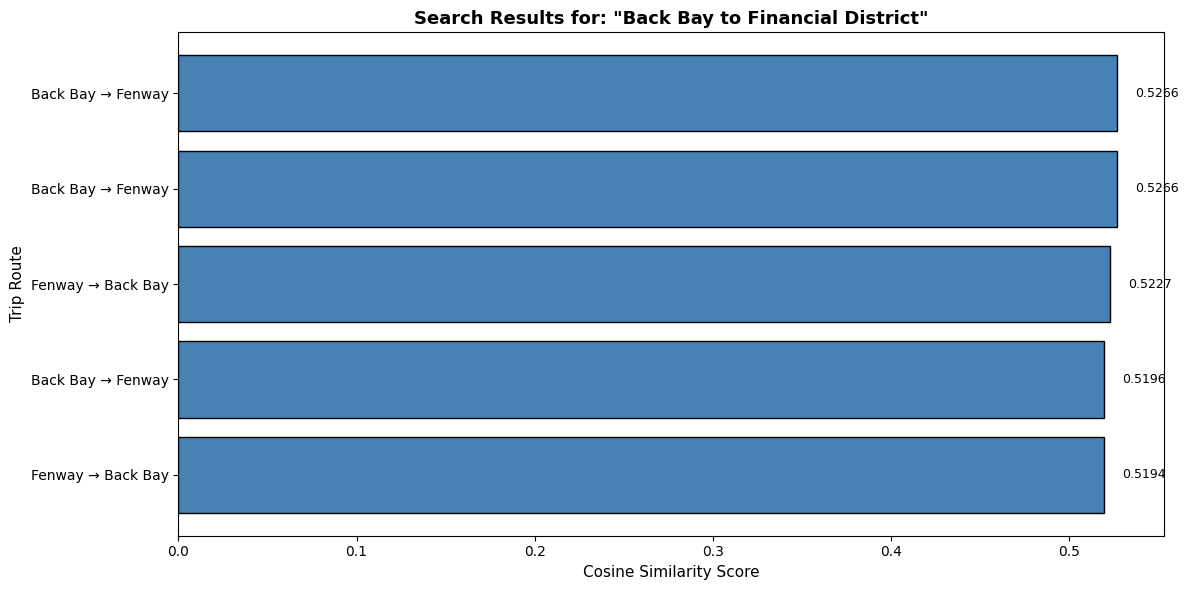

In [37]:
import matplotlib.pyplot as plt

# Test a single query first to debug
test_query = "Back Bay to Financial District"
test_results = search_corpus(test_query, k=5)

print(f"\nQuery: '{test_query}'")
print(f"Results found: {len(test_results)}")

# Simple visualization - just one query first
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

titles = [r['title'] for r in test_results]
scores = [r['score'] for r in test_results]

# Create horizontal bar chart
y_pos = np.arange(len(titles))
ax.barh(y_pos, scores, color='steelblue', edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(titles, fontsize=10)
ax.set_xlabel('Cosine Similarity Score', fontsize=11)
ax.set_ylabel('Trip Route', fontsize=11)
ax.set_title(f'Search Results for: "{test_query}"', fontsize=13, fontweight='bold')
ax.invert_yaxis()  # Highest score at top

# Add score labels on bars
for i, (title, score) in enumerate(zip(titles, scores)):
    ax.text(score + 0.01, i, f'{score:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()